In [1]:

import numpy as np
from skimage.color import rgb2gray,rgba2rgb
from skimage.measure import find_contours
from skimage import transform, feature, color , morphology , measure, segmentation, filters, draw, io
from commonfunctions import * 
from tabulate import tabulate
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from skimage.draw import rectangle

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [15]:
image = io.imread('michael.jpg')
image = io.imread('grade_sheet/1.jpg')
gray = rgb2gray(image)


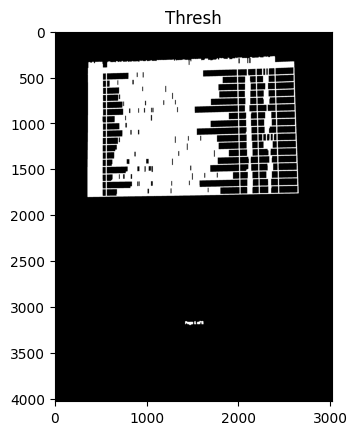

In [26]:
# initialize a rectangular kernel that is ~5x wider than it is tall,
# then smooth the image using a 3x3 Gaussian blur and then apply a
# blackhat morpholigical operator to find dark regions on a light
# background

# Initialize a rectangular kernel that is ~5x wider than it is tall
kernel = morphology.rectangle(51,11)

# Smooth the image using a 3x3 Gaussian blur
gray = filters.gaussian(gray, sigma=1)

# Apply a blackhat morphological operator to find dark regions on a light background
blackhat = morphology.black_tophat(gray, kernel)

# Compute the Scharr gradient of the blackhat image
grad = filters.scharr(blackhat)

# Scale the result into the range [0, 255]
grad = ((grad - np.min(grad)) / (np.max(grad) - np.min(grad)) * 255).astype("uint8")

# Apply a closing operation using the rectangular kernel to close gaps in between characters
grad = morphology.closing(grad, kernel)

# Apply Otsu's thresholding method
thresh = filters.threshold_otsu(grad)

# Finally, apply a dilation operation to enlarge foreground regions
thresh = morphology.dilation(grad >= thresh, morphology.square(3))

# Display the result
plt.imshow(thresh, cmap='gray')
plt.title("Thresh")
plt.show()


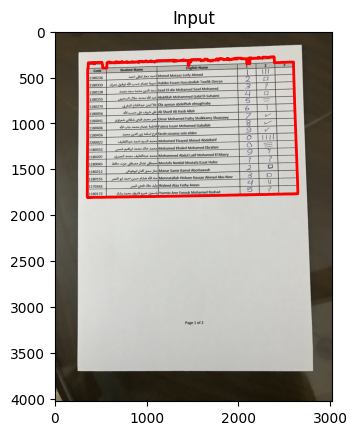

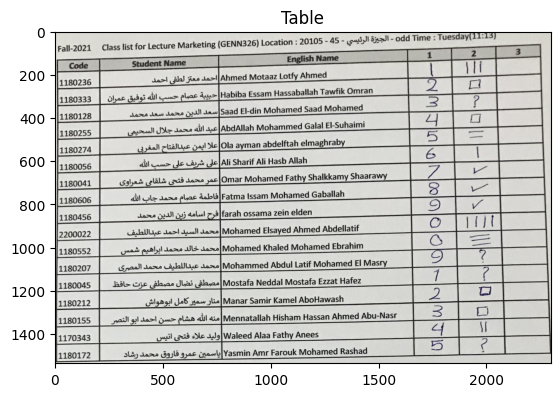

In [27]:

# Assuming 'thresh' is the binary threshold image

# Find contours in the thresholded image
contours = measure.find_contours(thresh, 0.8)

# Grab the largest contour, which we will assume is the stats table
table_contour = max(contours, key=lambda x: len(x))

# Convert the coordinates to integers
min_row, min_col = np.floor(np.min(table_contour, axis=0)).astype(int)
max_row, max_col = np.ceil(np.max(table_contour, axis=0)).astype(int)

# Extract the table from the input image
table = image[min_row:max_row, min_col:max_col]

# Show the original input image and the extracted table
plt.imshow(image)
plt.plot(table_contour[:, 1], table_contour[:, 0], linewidth=2, color='r')
plt.title("Input")
plt.show()

plt.imshow(table, cmap='gray')
plt.title("Table")
plt.show()


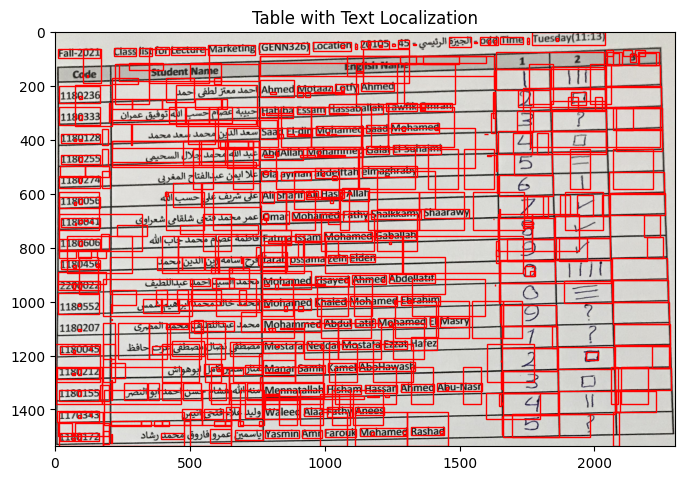

In [28]:
import pytesseract
from pytesseract import Output


# Convert the table to grayscale
table_gray = color.rgb2gray(table)


# Threshold the image to obtain binary text regions
binary_table = table_gray > filters.threshold_otsu(table_gray)




# Find connected components in the binary image
label_image = measure.label(binary_table)

# Set the PSM mode to detect sparse text
options = "--psm 6"
#options = "."

#show_images([binary_table],["table"])

# Initialize lists to store the coordinates and OCR'd text
coords = []
ocrText = []

# Loop over each connected component in the labeled image
for region in measure.regionprops(label_image):
    # Extract bounding box coordinates of the text region
    min_row, min_col, max_row, max_col = region.bbox

    # Extract the text and confidence using Tesseract OCR
    result = pytesseract.image_to_data(table[min_row:max_row, min_col:max_col], config=options, output_type=Output.DICT)

    # Loop over each text localization in the region
    for i in range(len(result["text"])):
        x = min_col + result["left"][i]
        y = min_row + result["top"][i]
        w = result["width"][i]
        h = result["height"][i]

        text = result["text"][i]
        conf = int(float(result["conf"][i]))

        # Filter out weak confidence text localizations
        if conf > 0:
            coords.append((x, y, w, h))
            ocrText.append(text)

# Display the table with bounding boxes around detected text
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(table, cmap='gray')

for (x, y, w, h) in coords:
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Table with Text Localization")
plt.show()



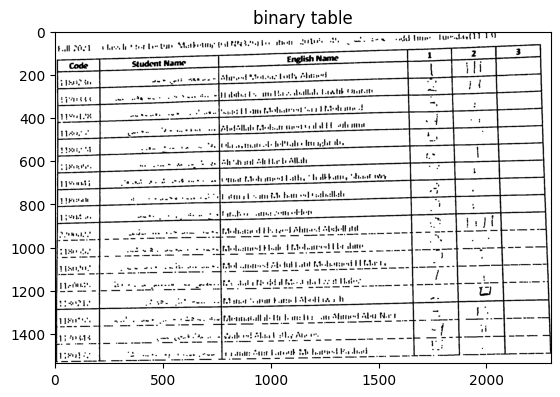

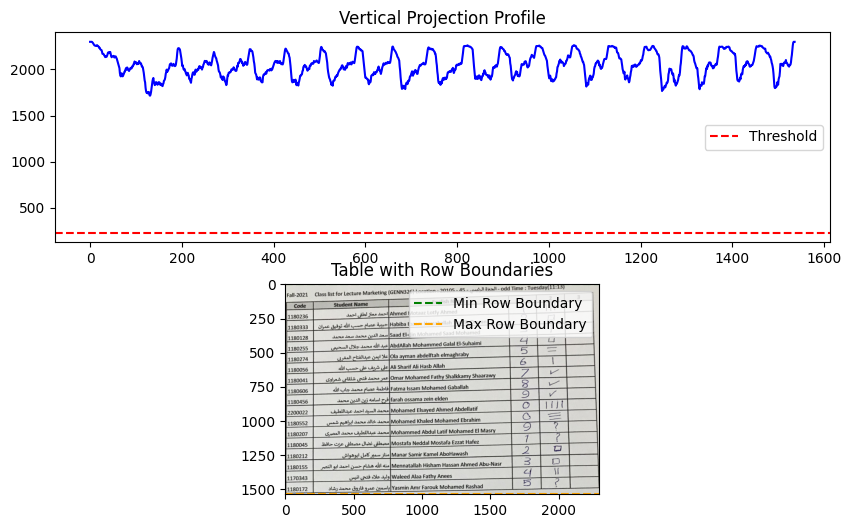

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, filters, morphology, measure

# Assuming 'table' is your image

# Convert the table to grayscale
table_gray = color.rgb2gray(table)

# Threshold the image to obtain binary text regions
binary_table = table_gray > filters.threshold_otsu(table_gray)

# Perform morphological closing to connect nearby text elements
binary_table_closed = morphology.closing(binary_table, morphology.square(5))
show_images([binary_table_closed], ["binary table"])

# Sum along the columns to get a 1D array representing the vertical projection profile
column_profile = np.sum(binary_table_closed, axis=1)

# Set a threshold to identify the column boundaries
threshold = 0.1 * np.max(column_profile)
column_boundaries = np.where(column_profile > threshold)[0]

# Extract the first and last column boundaries
min_row = column_boundaries[0]
max_row = column_boundaries[-1]

# Plot the vertical projection profile and boundaries for visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
ax1.plot(column_profile, color='blue')
ax1.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
ax1.legend()
ax1.set_title('Vertical Projection Profile')

ax2.imshow(table, cmap='gray')
ax2.axhline(y=min_row, color='green', linestyle='--', label='Min Row Boundary')
ax2.axhline(y=max_row, color='orange', linestyle='--', label='Max Row Boundary')
ax2.legend()
ax2.set_title('Table with Row Boundaries')

plt.show()


In [30]:
from skimage import io, color, measure, filters
import pytesseract
from pytesseract import Output
import matplotlib.pyplot as plt

# Assuming 'table' is the extracted table from the previous code

# Convert the table to grayscale
table_gray = color.rgb2gray(table)

# Threshold the image to obtain binary text regions
binary_table = table_gray > filters.threshold_otsu(table_gray)

# Find connected components in the binary image
label_image = measure.label(binary_table)

# Set the PSM mode to detect sparse text
options = "--psm 6"

# Initialize lists to store the coordinates and OCR'd text for the first column
first_column_coords = []
first_column_ocrText = []

# Loop over each connected component in the labeled image
for region in measure.regionprops(label_image):
    # Extract bounding box coordinates of the text region
    min_row, min_col, max_row, max_col = region.bbox

    # Extract the text and confidence using Tesseract OCR
    result = pytesseract.image_to_data(table[min_row:max_row, min_col:max_col], config=options, output_type=Output.DICT)

    # Loop over each text localization in the region
    for i in range(len(result["text"])):
        x = min_col + result["left"][i]
        y = min_row + result["top"][i]
        w = result["width"][i]
        h = result["height"][i]

        text = result["text"][i]
        conf = int(float(result["conf"][i]))

        # Filter out weak confidence text localizations
        if conf > 0:
            first_column_coords.append((x, y, w, h))
            first_column_ocrText.append(text)

# Determine the minimum x-coordinate as the column boundary
column_boundary = min(coord[0] for coord in first_column_coords)

# Display the table with bounding boxes around the first column of detected text
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(table, cmap='gray')

for (x, y, w, h) in first_column_coords:
    rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

ax.set_title("Table with First Column Text Localization")
plt.show()

# Print the OCR'd text in the first column
print("First Column OCR'd Text:")
for text in first_column_ocrText:
    print(text)


In [ ]:
# extract all x-coordinates from the text bounding boxes, setting the
# y-coordinate value to zero
xCoords = [(c[0], 0) for c in coords]

# apply hierarchical agglomerative clustering to the coordinates
clustering = AgglomerativeClustering(
	n_clusters=None,
	affinity="manhattan",
	linkage="complete",
	distance_threshold=25
)
clustering.fit(xCoords)

# initialize our list of sorted clusters
sortedClusters = []

# loop over all clusters
for l in np.unique(clustering.labels_):
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# verify that the cluster is sufficiently large
	if len(idxs) > 2:
		# compute the average x-coordinate value of the cluster and
		# update our clusters list with the current label and the
		# average x-coordinate
		avg = np.average([coords[i][0] for i in idxs])
		sortedClusters.append((l, avg))

# sort the clusters by their average x-coordinate and initialize our
# data frame
sortedClusters.sort(key=lambda x: x[1])
df = pd.DataFrame()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


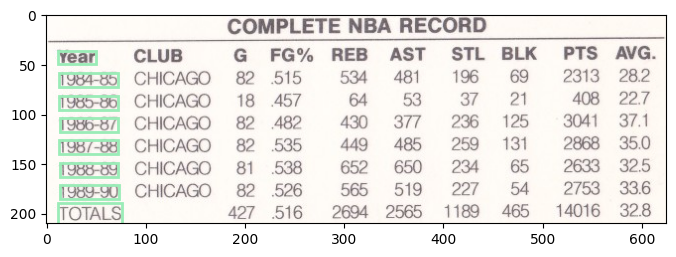

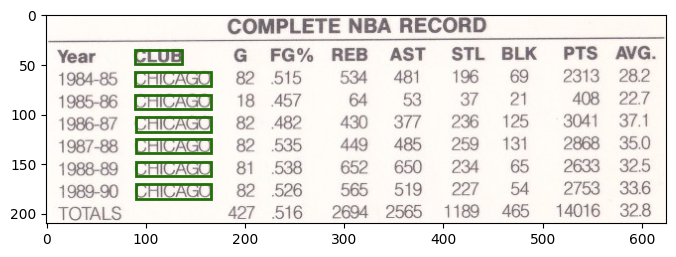

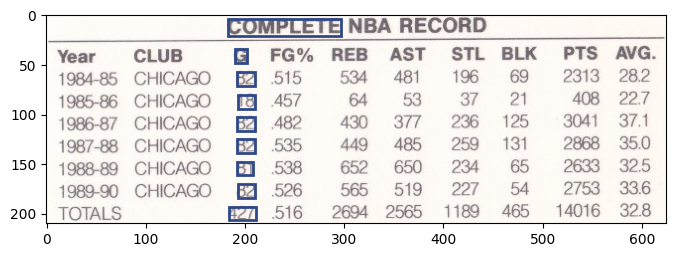

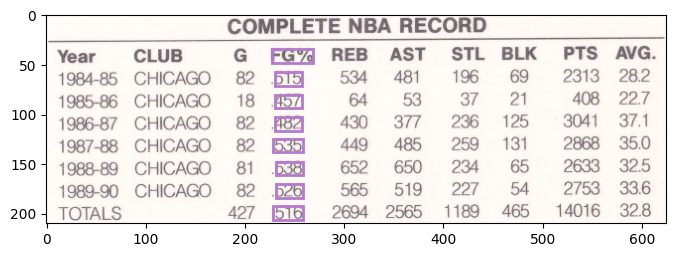

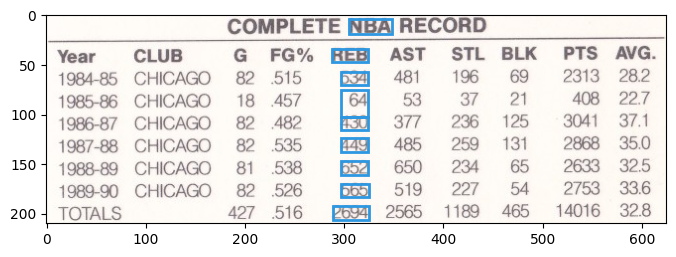

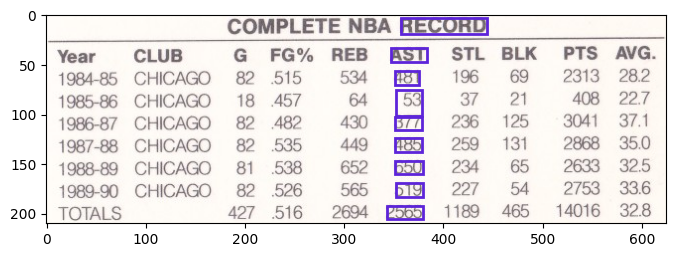

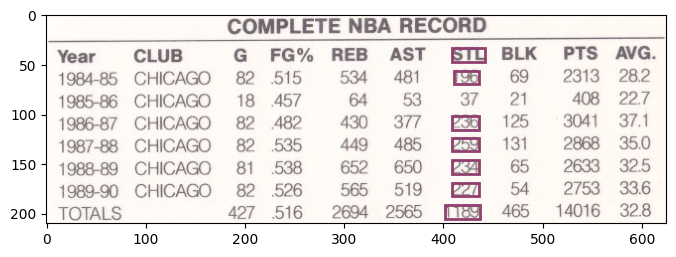

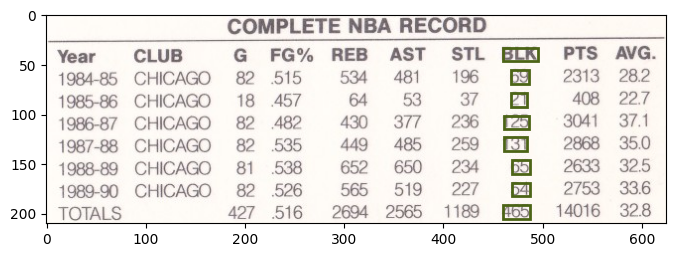

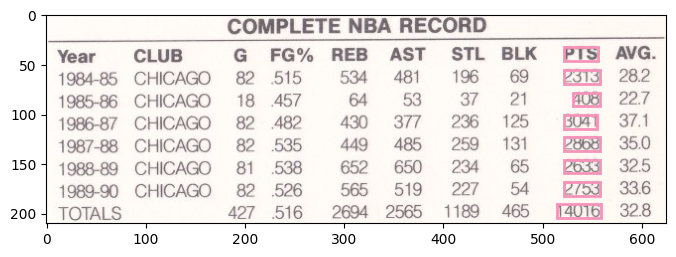

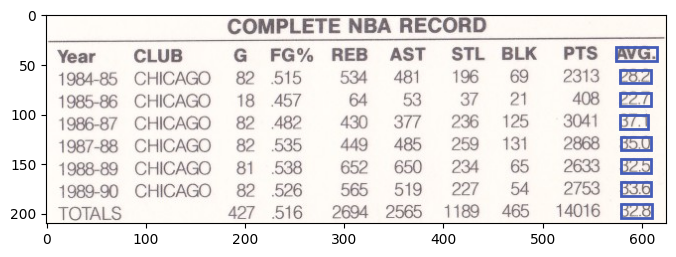

In [ ]:
# loop over the clusters again, this time in sorted order
for (l, _) in sortedClusters:
	# extract the indexes for the coordinates belonging to the
	# current cluster
	idxs = np.where(clustering.labels_ == l)[0]

	# extract the y-coordinates from the elements in the current
	# cluster, then sort them from top-to-bottom
	yCoords = [coords[i][1] for i in idxs]
	sortedIdxs = idxs[np.argsort(yCoords)]

	# Generate a random color 
	color = np.random.rand(3)

	# loop over the sorted indexes
	fig, ax = plt.subplots(figsize=(8, 8))
	ax.imshow(table, cmap='gray')
	for i in sortedIdxs:
		# extract the text bounding box coordinates and draw the
		# bounding box surrounding the current element
		(x, y, w, h) = coords[i]
		rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
		ax.add_patch(rect)
	plt.show()
	

	# extract the OCR'd text for the current column, then construct
	# a data frame for the data where the first entry in our column
	# serves as the header
	cols = [ocrText[i].strip() for i in sortedIdxs]
	currentDF = pd.DataFrame({cols[0]: cols[1:]})

	# concatenate *original* data frame with the *current* data
	# frame (we do this to handle columns that may have a varying
	# number of rows)
	df = pd.concat([df, currentDF], axis=1)

In [ ]:
# replace NaN values with an empty string and then show a nicely
# formatted version of our multi-column OCR'd text
df.fillna("", inplace=True)
print(tabulate(df, headers="keys", tablefmt="psql"))

+----+---------+---------+------------+-------+-------+----------+-------+-------+-------+--------+
|    | Year    | CLUB    | COMPLETE   | FG%   | NBA   | RECORD   | STL   | BLK   | PTS   | AVG.   |
|----+---------+---------+------------+-------+-------+----------+-------+-------+-------+--------|
|  0 | 1984-85 | CHICAGO | G          | 515   | REB   | AST      | 19%   | 69    | 2313  | 282    |
|  1 | 1985-86 | CHICAGO | 82         | .457  | 534   | 481      | 236   | A     | 408   | 227    |
|  2 | 1986-87 | CHICAGO | 18         | 482   | 64    | 53       | 259   | 125   | 3041  | 37.1   |
|  3 | 1987-88 | CHICAGO | 82         | 535   | 430   | 377      | 234   | 131   | 2868  | 635.0  |
|  4 | 1988-89 | CHICAGO | 82         | 538   | 449   | 485      | 227   | 65    | 2633  | 325    |
|  5 | 1989-90 | CHICAGO | 81         | 526   | 652   | 650      | 1189  | 54    | 2763  | «33.6  |
|  6 | TOTALS  |         | 82         | 516   | 565   | 519      |       | 465   | 14016 | 328    |


In [ ]:

def plt_imshow(title, image):
	# convert the image frame BGR to RGB color space and display it
	image = rgb2gray(image)
	plt.imshow(image)
	plt.title(title)
	plt.grid(False)
	plt.show()


# write our table to disk as a CSV file
print("[INFO] saving CSV file to disk...")
df.to_csv("output.csv")


[INFO] saving CSV file to disk...
